# Load and inspect  data files:

# 1/ ireland historical news
Context
This news dataset is a collection of 1.42 million news headlines published by The Irish Times based in Ireland.

Created over 159 Years ago the agency provides a long term birds eye view of the happenings of Europe.

Agency Website: https://www.irishtimes.com

The historical reels can be explored thoroughly via the archives portal.

Content
Format: CSV ; 6 files

1 publish_date: Date of the article being published in yyyyMMdd format
2 headline_category: Category of the headline, Ascii, dot delimited, lowercase values
3 headline_text: Text of the Headline in English
Start Date: 1996-01-01 End Date: 2018-12-31

Total Events: 1,425,460

In [1]:
import pandas
import numpy

data = [pandas.read_csv('xaa')]
columns = data[0].columns
data.extend([pandas.read_csv(filename,
                             header=None, 
                             names=columns) for filename in ('xab','xac','xad','xae','xaf')])
headlines = pandas.concat(data)
headlines.index = numpy.arange(headlines.shape[0])
headlines['publish_date']=pandas.to_datetime(headlines['publish_date'],format='%Y%m%d')
headlines

,publish_date,headline_category,headline_text
0,1996-01-02,news,UUP sees possibility of voting Major out
1,1996-01-02,news,Pubs targeted as curbs on smoking are extended
2,1996-01-02,news,Papers reveal secret links with O'Neill cabinet
3,1996-01-02,news,Domestic chaos as Italy takes EU presidency
4,1996-01-02,news,Learning about the star to which we owe life
5,1996-01-02,news,EU proposal for 'skills cards' to detail educa...
6,1996-01-02,news,Roads authority asked to switch to use of conc...
7,1996-01-02,news,UCD cancels intake into evening course
8,1996-01-02,news,When days are seconds longer
9,1996-01-02,news,John Major's future may lie in unionist hands


# 2/ company_selection.csv
A selection of 20,000 startup companies names

In [2]:
companies = pandas.read_csv('company_selection.csv',index_col=0)
companies

,name,description
446617,PHI Integration,They are the technology enabler helping Busine...
511854,Fintech PRRB,Fintech PRRB is a financial technology company...
420327,Reverse Ionizer,Reverse Ionizerâ¢ has developed a revolutiona...
434431,UNH3O,UNH3O Powering personalized relationships betw...
274244,Rhyme&Reason Clothing,"We offer high quality, every-day clothing - T-..."
299626,LOCI,LOCIâs mission is to disrupt the global pate...
53235,Tocquigny Advertising,Tocquigny was founded by Yvonne Tocquigny. Yvo...
263572,Visor,Visor SA designs and develops market intellige...
217649,Anakam,Anakam is focused on the development of multi-...
432910,ASBV,ASBV focuses on early and mid-term venture cap...


# The objective of this take home is to link news and companies

# Natural Language processing:

1/ Link news and companies

In [3]:
import pymongo
mongo = pymongo.mongo_client.MongoClient()
db = mongo.ey
collection = db.headlines
collection.insert_many([row.to_dict()
                       for (index,row) in headlines.iterrows()])
collection.create_index([('headline_text',pymongo.TEXT)])

data = []
for name in companies['name']:
    for headline in collection.find({'$text':{'$search':'"{}"'.format(name),
                                              '$caseSensitive':True}}):
        headline['company']=name
        data.append(headline)
matched_headlines = pandas.DataFrame(data)
headlines['publish_date']=pandas.to_datetime(headlines['publish_date'],format='%Y%m%d')
matched_headlines

,_id,publish_date,headline_category,headline_text,company
0,5d93048d4adb12ac9f5e1d3b,1998-12-10,opinion.letters,Credit For Tax Credits,Tax Credit
1,5d9304924adb12ac9f6d4cc9,2014-07-17,business.technology,Lucidity Digital rebranded as Isobar,Lucid
2,5d9304904adb12ac9f692d79,2010-04-07,culture.books,Lucid and in-depth portrait of troubled country,Lucid
3,5d93048f4adb12ac9f63ffd2,2005-03-25,news,Pope weak but 'Lucid' on Good Friday,Lucid
4,5d9304904adb12ac9f68fc3a,2010-02-05,opinion,Lucid grassroots account of 1916 Rising explor...,Lucid
5,5d9304924adb12ac9f706721,2017-11-04,culture.books,Lucid but flawed: Paschal Donohoe reviews Yani...,Lucid
6,5d9304904adb12ac9f689c30,2009-10-16,opinion,Lucid insight into eccentric world and inner d...,Lucid
7,5d93048d4adb12ac9f5e7012,1999-04-21,opinion,Similarity of verdicts on different acts absurd,Similarity
8,5d93048f4adb12ac9f64c23a,2006-01-28,business,Tech veterans reap reward from Similarity sale,Similarity
9,5d93048e4adb12ac9f604960,2001-04-18,opinion.letters,Boston Versus Berlin,Versus


In [4]:
matched_headlines['company'].value_counts()

United         4776
99             2081
Collins        1004
Ranger          914
Roche           901
               ... 
EisnerAmper       1
7-Eleven          1
Primer            1
Automattic        1
IMS Maxims        1
Name: company, Length: 606, dtype: int64

2/ Propose 3 features of interest and 2 dependent variables

## Features of interest
1. Date
2. Headline category
3. Keywords from company description

## Targets
1. Number of mentions of company
2. Keywords in headline

Significance of keywords will be calculated with a LogEntropy model.

# Exploratory Data Analysis:

Review the features and targets

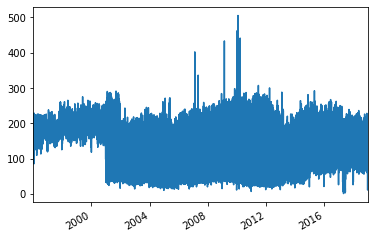

In [5]:
%matplotlib inline
import gensim



headlines['publish_date'].value_counts().sort_index().plot.line()

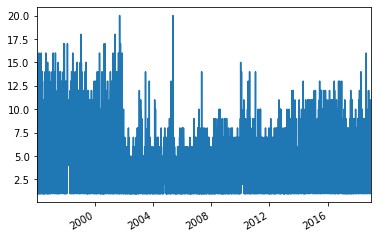

In [6]:
matched_headlines['publish_date'].value_counts().sort_index().plot.line()

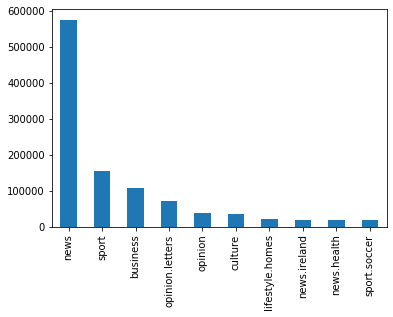

In [7]:
headlines['headline_category'].value_counts().nlargest(10).plot.bar()

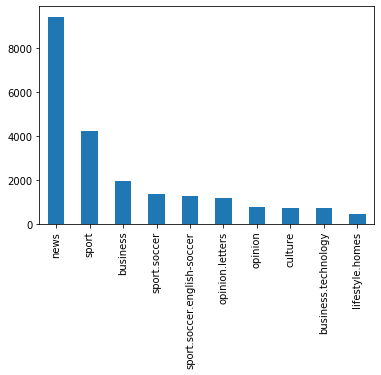

In [8]:
matched_headlines['headline_category'].value_counts().nlargest(10).plot.bar()

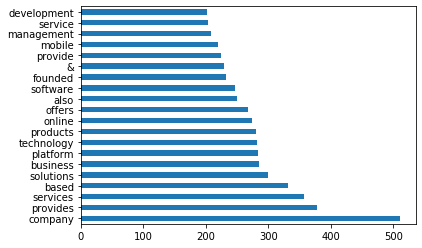

In [11]:
import collections
import nltk
class Corpus(object):
    def __init__(self,*args):
        self.stopwords = nltk.corpus.stopwords.words('english')
        all_data = pandas.concat(args).str.split()
        self.dictionary = gensim.corpora.dictionary.Dictionary([self.filter_words(doc) for doc in all_data])
        self.dictionary.filter_extremes()
        self.model = gensim.models.logentropy_model.LogEntropyModel([self.dictionary.doc2bow(self.filter_words(doc))
                                                                     for doc in all_data])
        self.lsi = gensim
        
    def filter_words(self,document):
        return [word for word in document
                if word.lower() not in self.stopwords]
        
    def __call__(self,column):
        return self.model[[self.dictionary.doc2bow(self.filter_words(doc))
                           for doc in column.str.split()]]
    
logent = Corpus(companies['description'],headlines['headline_text'])
significance = collections.defaultdict(float)
def significant_words(corpus):
    for doc in logent(corpus):
        for (n,h) in doc:
            significance[n]+=h
    return pandas.Series({logent.dictionary[n]:h
                          for (n,h) in significance.items()})

significant_words(companies['description']).nlargest(20).plot.barh()

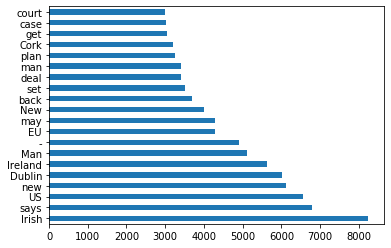

In [12]:
significant_words(headlines['headline_text']).nlargest(20).plot.barh()

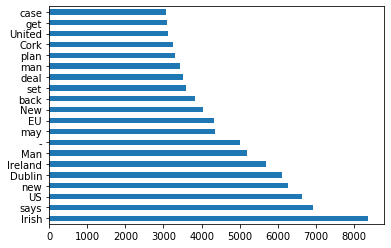

In [13]:
significant_words(matched_headlines['headline_text']).nlargest(20).plot.barh()

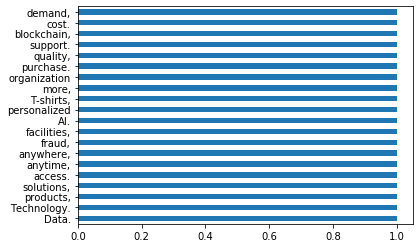

In [14]:
ratios = significant_words(matched_headlines['headline_text'])/significant_words(headlines['headline_text'])
ratios.nlargest(20).plot.barh()

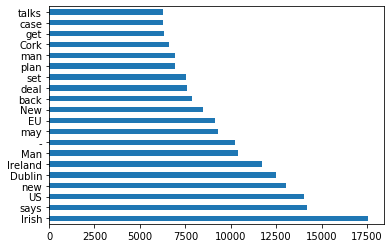

In [15]:
significant_words(headlines.loc[headlines['headline_category']=='business']['headline_text']).nlargest(20).plot.barh()

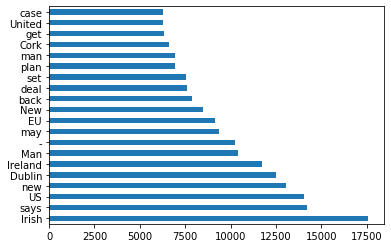

In [16]:
significant_words(matched_headlines.loc[matched_headlines['headline_category']=='business']['headline_text']).nlargest(20).plot.barh()

# Propose a modelling technique and the reasons behind your choice
Classification
Regression
Clustering
Time Series Forecast


Overall, we see little difference between the most significant words taken from headlines, whether they are taken form the overall set, from the matched set, or just from business headlines. However, by using clustering we can identify groups within the headlines that are significantly different. We can similarly identify groups of companies  by similarities in their descriptions. For each of these clusterings, we can investigate their most significant words, their timelines, their relationships to categories, and the possiblitity of predicting headline cluster from company cluster.

Before clustering, we need to reduce the dimensionality of the data. I will use LSI for this.

1/ Prepare your datasets 

In [18]:
lsi = gensim.models.LsiModel(logent(pandas.concat([headlines['headline_text'],companies['description']])))

headline_vectors = pandas.DataFrame(gensim.matutils.corpus2dense(lsi[logent(matched_headlines['headline_text'])],lsi.num_topics).T,
                                    index = matched_headlines.index)

description_vectors = pandas.DataFrame(gensim.matutils.corpus2dense(lsi[logent(companies['description'])],lsi.num_topics).T,
                                       index = companies['name'])

2/ Propose a list of algorithms and how to evaluate them systematically

We wish to obtain an initially unknown number of clusters from high-dimensional data. For this, hierarchical clustering will be suitable. 

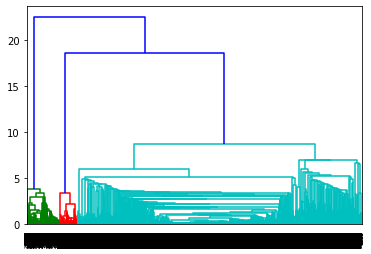

In [20]:
import scipy.cluster.hierarchy
import sklearn
import sklearn.cluster
import matplotlib

def dendrogram(data):
    result=matplotlib.pyplot.gca()
    scipy.cluster.hierarchy.dendrogram(scipy.cluster.hierarchy.ward(data.values),ax=result)
    return result
    
dendrogram(headline_vectors)   

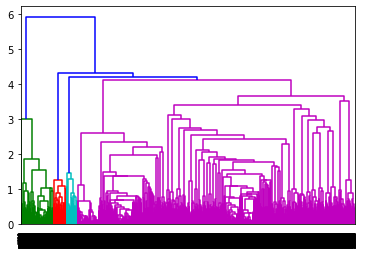

In [21]:
dendrogram(description_vectors)

We are seeing small numbers of clusters in each case, one of which is very large and messy, and thus not likely to be useful. Let us see if combining headlines per company makes any difference.

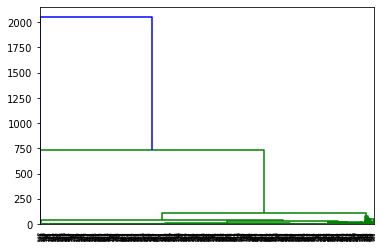

In [23]:
headlines_per_company = headline_vectors.merge(matched_headlines['company'],
                                              left_index=True,
                                              right_index=True).groupby('company').sum()
dendrogram(headlines_per_company)

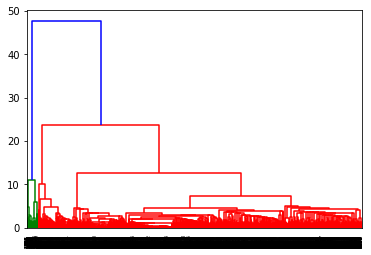

In [27]:
headlines_per_day = headline_vectors.merge(matched_headlines['publish_date'],
                                           left_index=True,
                                           right_index=True).groupby('publish_date').sum()
dendrogram(headlines_per_day)

3/ Choose an algorythm and explain why

Quite frankly, this is getting me nowhere and I need to change tack just so that I have some results at all. I will try to predict headline category from the LSI vectors of the headlines. For this I will use Random Forests, because the headline category is highly unbalanced. I will train on a randomly chosen 70% of the dataset and test on the rest, using Cohen's kappa as the metric, since this is suitable for unbalanced datasets

4/ Present the results and possible improvements

In [28]:
import random
import sklearn.ensemble
import sklearn.metrics

classifier = sklearn.ensemble.RandomForestClassifier()
n=matched_headlines.shape[0]
training_dataset = random.sample(range(n),n*7//10)
test_dataset = [i for i in range(n) if i not in training_dataset]
classifier.fit(headline_vectors.loc[training_dataset].values,matched_headlines.loc[training_dataset,'headline_category'].values)
predictions = classifier.predict(headline_vectors.loc[test_dataset])
sklearn.metrics.cohen_kappa_score(matched_headlines.loc[test_dataset,'headline_category'].values,
                                  predictions)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.2498141479624686

5/ Extra: Build a pipeline / storage utility for the model